<a href="https://colab.research.google.com/github/dinianggraini13/SKRIPSI/blob/main/CNN-70%25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -U imbalanced-learn

In [2]:
from imblearn.over_sampling import SMOTE
from keras.utils import to_categorical

In [3]:
#Machine Learning Libraries
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
import nltk
from nltk import word_tokenize, WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import spacy
import matplotlib.pyplot as plt # Visualisasi data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

import os
import collections

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#Deep Learning Libraries

#For Word2Vec Embedding
from gensim import models
import gensim
from gensim.models import Word2Vec

#For Building Model
import tensorflow as tf
import keras
from keras import regularizers, backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Embedding, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model

In [5]:
!pip install mlxtend

In [6]:
from mlxtend.plotting import plot_confusion_matrix

LOAD DATASET

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
data = pd.read_csv('hasilreviews_label.csv')

# Membuat DataFrame 'hasilreviews_label' dari data yang diunggah
hasilreviews_label = pd.DataFrame(data, columns=['content', 'label'])

# Cetak beberapa baris pertama dari DataFrame 'hasilreviews_label' untuk memeriksa hasilnya
print(hasilreviews_label.head())


                                             content  label
0  I literally can't use the app. It won't let me...      0
1  The platform has potential, but the app, which...      1
2  Pretty good for a first launch!! Its easy to u...      1
3  Currently, it's very challenging to use. It's ...      0
4  Meh. Not the greatest experience on a Chromebo...      0


In [9]:
data['label'].value_counts()

0    15703
2    14758
1     3008
Name: label, dtype: int64

PREPROCESSING

In [10]:
# Memuat model bahasa spaCy (ganti 'en_core_web_sm' dengan model yang sesuai)
nlp = spacy.load('en_core_web_sm')

# Fungsi untuk tokenization, stopword removal, dan stemming
def preprocess_text(text):
    # Menghapus tanda baca
    translator = str.maketrans('', '', string.punctuation)
    text_no_punct = text.translate(translator)

    # Menghapus karakter non-ASCII (emotikon umumnya non-ASCII)
    text_no_emoticons = re.sub(r'[^\x00-\x7F]+', ' ', text_no_punct)

    # Tokenization
    tokens = word_tokenize(text_no_emoticons.lower())

    # Stopword removal using spaCy
    doc = nlp(" ".join(tokens))
    filtered_tokens = [token.text for token in doc if not token.is_stop]

    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

    return ' '.join(stemmed_tokens)

# Muat data Anda dan bersihkan teks
data = pd.read_csv("hasilreviews_label.csv")

# Tambahkan kolom untuk hasil preprocessing
data['cleaned_content'] = data['content'].apply(preprocess_text)

# Fungsi untuk tokenisasi dan penghapusan stopwords
def tokenize(text):
    doc = nlp(text)
    return [token.text for token in doc if not token.is_stop]

# Tambahkan kolom 'tokenized_content'
data['tokenized_content'] = data['cleaned_content'].apply(tokenize)

# Tampilkan dataframe data sebelum dan sesudah preprocessing
print("Data Sebelum Preprocessing:")
print(data[['content']])

print("\nData Sesudah Preprocessing:")
print(data[['cleaned_content', 'tokenized_content']])

Data Sebelum Preprocessing:
                                                 content
0      I literally can't use the app. It won't let me...
1      The platform has potential, but the app, which...
2      Pretty good for a first launch!! Its easy to u...
3      Currently, it's very challenging to use. It's ...
4      Meh. Not the greatest experience on a Chromebo...
...                                                  ...
33464             Twitter is better then this copied app
33465                                         Cheap copy
33466  App some Designs copied from Twitter ... I thi...
33467                                                 Ok
33468                  T don't like very so the nice 👍🏻❤

[33469 rows x 1 columns]

Data Sesudah Preprocessing:
                                         cleaned_content  \
0      liter nt use app wo nt let search post look no...   
1      platform potenti app main way use platform mom...   
2      pretti good launch easi use selfexplanatori d 

### **WORDCLOUD**

WordCloud for Label '0':


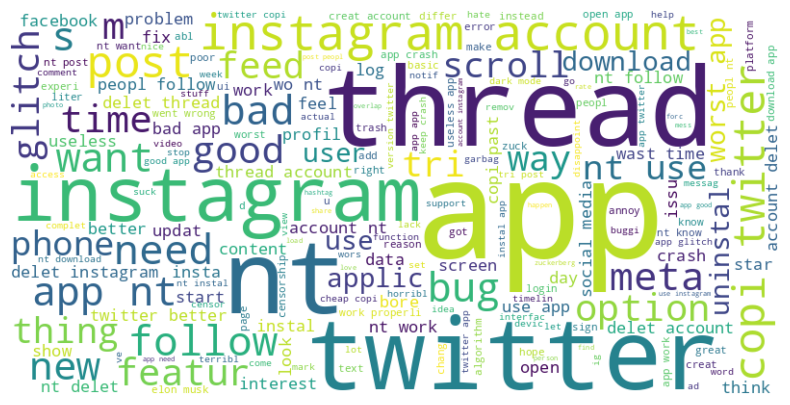

WordCloud for Label '1':


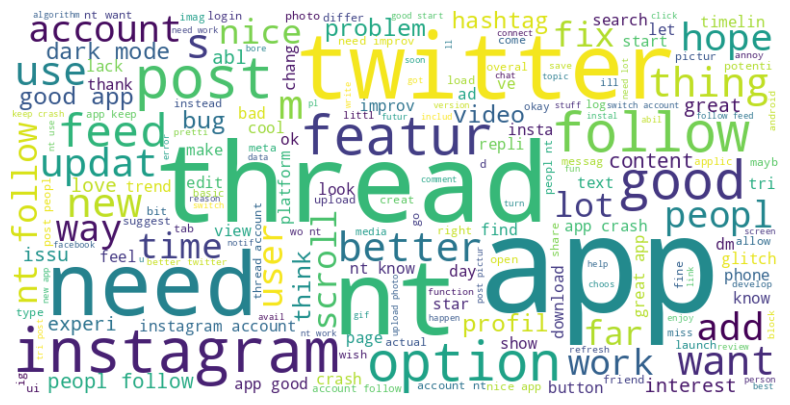

WordCloud for Label '2':


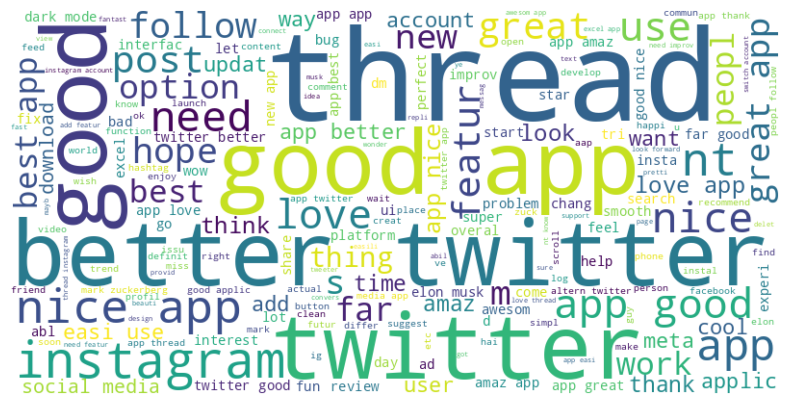

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Fungsi untuk membuat WordCloud
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Membuat WordCloud untuk setiap label
labels = data['label'].unique()

for label in labels:
    # Menggabungkan teks dari semua review dengan label tertentu
    text_for_label = ' '.join(data[data['label'] == label]['cleaned_content'])

    # Membuat WordCloud
    print(f"WordCloud for Label '{label}':")
    generate_wordcloud(text_for_label)


SPLIT DATA

In [12]:
# Memisahkan data menjadi data sementara (temp_data) dan data pengujian
temp_data, data_test = train_test_split(data, test_size=0.3, random_state=42)

# Memisahkan data sementara menjadi data pelatihan dan data validasi
data_train, data_val = train_test_split(temp_data, test_size=0.25, random_state=42)

print("Data train: %s, Data val: %s, Data test: %s." % (data_train.shape[0], data_val.shape[0], data_test.shape[0]))

Data train: 17571, Data val: 5857, Data test: 10041.


Check Vocab Size and max sentence lenght

In [13]:
#data train
all_training_words = [word for tokens in data_train["tokenized_content"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokenized_content"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))

print("Data train total words : %s , Vocabulary size : %s" % (len(all_training_words), len(TRAINING_VOCAB)))

Data train total words : 123225 , Vocabulary size : 8416


In [14]:
#data val
all_validation_words = [word for tokens in data_val["tokenized_content"] for word in tokens]
validation_sentence_lengths = [len(tokens) for tokens in data_val["tokenized_content"]]
VALIDATION_VOCAB = sorted(list(set(all_validation_words)))

print("Data validation total words: %s, Vocabulary size: %s" % (len(all_validation_words), len(VALIDATION_VOCAB)))


Data validation total words: 39982, Vocabulary size: 4370


In [15]:
#data test
all_test_words = [word for tokens in data_test["tokenized_content"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokenized_content"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("Data test total words : %s , Vocabulary size : %s" % (len(all_test_words), len(TEST_VOCAB)))

Data test total words : 69745 , Vocabulary size : 6113


# Word Embeddings

In [16]:
from gensim.models import Word2Vec

# Membangun model Word2Vec
model = Word2Vec(data['tokenized_content'], vector_size=100, window=5, min_count=1, sg=0)

# Simpan model Word2Vec
model.save("word2vec_model.model")

In [17]:
vector = model.wv['use']
print(vector)

[-0.5016905   0.12387642  1.0627768  -0.43381864  0.19247328 -0.5766778
  0.3255074   1.6684716   0.02196702 -0.30554664 -0.3234135  -1.1242108
 -0.4369339  -0.2539886   0.05599968 -0.32890734  0.16669817 -0.37561882
 -0.0276548  -1.6597233   0.06973293  0.9555701   0.55713785 -0.13993005
 -0.6335881   0.67062944 -0.8783564  -0.9708489  -0.3323669   0.3510624
  0.37182495  0.0509613  -0.02774133 -1.0492135  -0.8118446   1.0718988
 -0.5109331  -0.90070367  0.02839584 -1.0208713   0.5137229  -0.31526718
 -0.29863462 -0.48985535  0.38795567 -0.3825719  -0.56612873 -0.15158126
  0.16678505 -0.00622528  0.4429722  -0.14715049  0.19444633  0.15301406
 -0.04958772  0.53986573 -0.02827367  0.47937936 -0.44993618  0.1524968
 -0.25692368  0.04673452  0.14444102 -0.1353      0.03105424  0.41050202
  0.10535575  0.3783615  -0.56820095  0.5469779  -0.3148145   0.8988008
  0.19220334 -0.14060467  0.62542045  0.1715717  -0.09631908 -0.21108557
 -0.08992236  0.06261929 -0.6414067  -0.3388246  -0.50630

In [18]:
similar_words = model.wv.most_similar(positive=[vector], topn=1)
print(similar_words)


[('use', 1.0)]


In [19]:
#max sequence length
data_train['doc_len'] = data_train['content'].apply(lambda words: len(words.split(' ')))
max_seq_len = np.max(data_train['doc_len'])+1


In [20]:
max_seq_len

108

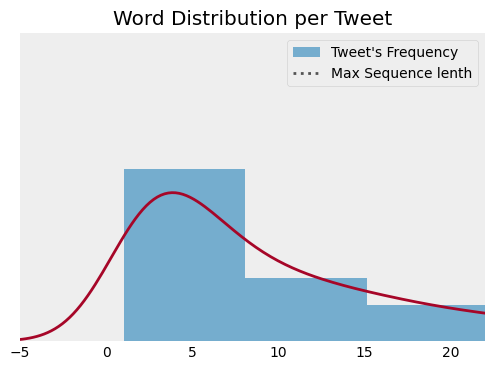

In [21]:
#Plot
fig, ax = plt.subplots(figsize=(6,4))

data_train['doc_len'].plot(kind='hist',
                      density=True,
                      alpha=0.65,
                      bins=15,
                      label="Tweet's Frequency")

data_train['doc_len'].plot(kind='kde', label='')

ax.set_xlim(-5, 22)
ax.set_xlabel("")
ax.set_ylim(0, 0.13)
ax.set_yticks([])
ax.set_ylabel("")
ax.set_title("Word Distribution per Tweet")
ax.grid(False)
ax.axvline(x=max_seq_len, alpha=0.65, color='k', linestyle=':', label='Max Sequence lenth')
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)

plt.legend()
plt.show()

Tokenize and Pad sequences

In [22]:
raw_docs_train = data_train['content'].tolist()
raw_docs_val = data_val['content'].tolist()
raw_docs_test = data_test['content'].tolist()

In [23]:
# Tokenizing input data for training
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(raw_docs_train)
word_seq_train = tokenizer.texts_to_sequences(raw_docs_train)
word_seq_test = tokenizer.texts_to_sequences(raw_docs_test)
word_seq_val = tokenizer.texts_to_sequences(raw_docs_val)

word_index = tokenizer.word_index
print('Dictionary Size: ', len(word_index))


Dictionary Size:  12800


In [24]:
# Tentukan panjang maksimum urutan kata yang sesuai berdasarkan data
max_seq_len = 100  # Contoh: Anda dapat mengatur panjang maksimum menjadi 100

# Lakukan padding pada urutan kata untuk data pelatihan
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)

# Lakukan padding pada urutan kata untuk data validasi
word_seq_val = sequence.pad_sequences(word_seq_val, maxlen=max_seq_len)

# Lakukan padding pada urutan kata untuk data pengujian
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)


In [25]:
len(word_seq_test)

10041

Train Embeddings Weights

In [26]:
#dimension
EMBEDDING_DIM = 100

In [27]:
train_embedding_weights = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, index in word_index.items():
    if word in model.wv:
        train_embedding_weights[index, :] = model.wv[word]
    else:
        train_embedding_weights[index, :] = np.random.rand(EMBEDDING_DIM)

print(train_embedding_weights.shape)


(12801, 100)


# Hyperparameter CNN

In [28]:
lr = 0.01
batch_size  = 32
num_epochs  = 10
num_filters = 128
filter_size = 2

In [29]:
nb_words = len(word_index)
nb_words

12800

In [30]:
# Kolom label yang berisi nilai 0, 1, 2
one_hot_labels = to_categorical(data_train['label'], num_classes=3)
# train_labels = to_categorical(data_train['label'], num_classes=3)
val_labels = to_categorical(data_val['label'], num_classes=3)
test_labels = to_categorical(data_test['label'], num_classes=3)

In [31]:
train_labels = one_hot_labels

In [32]:
# Inisialisasi objek SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

In [33]:
# Reshape data pelatihan untuk dimasukkan ke SMOTE
word_seq_train_reshaped = word_seq_train.reshape((word_seq_train.shape[0], -1))

# Lakukan oversampling dengan SMOTE
word_seq_train_resampled, one_hot_labels_resampled = smote.fit_resample(word_seq_train_reshaped, one_hot_labels)

# Kembalikan bentuk asli
word_seq_train_resampled = word_seq_train_resampled.reshape((word_seq_train_resampled.shape[0], max_seq_len, -1))

# Update variabel train_labels dengan hasil oversampling
train_labels_resampled = to_categorical(np.argmax(one_hot_labels_resampled, axis=1), num_classes=3)

In [34]:
# Lakukan one-hot encoding pada label untuk digunakan oleh SMOTE
one_hot_labels_before_smote = to_categorical(data_train['label'], num_classes=3)

# Hitung jumlah sampel untuk setiap kelas pada data pelatihan sebelum SMOTE
class_distribution_before_smote = np.sum(one_hot_labels_before_smote, axis=0)

# Tampilkan distribusi kelas sebelum SMOTE
print("Class Distribution Before SMOTE:")
for i, count in enumerate(class_distribution_before_smote):
    print(f"Class {i}: {count} samples")

Class Distribution Before SMOTE:
Class 0: 8237.0 samples
Class 1: 1594.0 samples
Class 2: 7740.0 samples


In [35]:
# Hitung jumlah sampel untuk setiap kelas pada data pelatihan setelah SMOTE
class_distribution_after_smote = np.sum(one_hot_labels_resampled, axis=0)

# Cetak distribusi kelas
print("Class Distribution After SMOTE:")
for i, count in enumerate(class_distribution_after_smote):
    print(f"Class {i}: {count} samples")


Class Distribution After SMOTE:
Class 0: 8237 samples
Class 1: 8237 samples
Class 2: 8237 samples


In [36]:
#early stopping for avoid overfitting model
#early_stopping = EarlyStopping(monitor='val_loss',
                               #min_delta=0.01,
                               #patience=3,
                               #verbose=1)

#callbacks_list = [early_stopping]

# Building Model CNN

In [37]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.utils import to_categorical
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from keras.callbacks import ModelCheckpoint, Callback


In [38]:
num_classes=3

model = Sequential(name='model')

model.add(Embedding(nb_words+1, EMBEDDING_DIM,
                    weights=[train_embedding_weights],
                    input_length=max_seq_len,
                    trainable=False))

model.add(Conv1D(num_filters, filter_size, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Conv1D(num_filters, filter_size, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(GlobalMaxPooling1D())

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dense(num_classes, activation='softmax'))

adam = Adam(lr=lr)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1280100   
                                                                 
 conv1d (Conv1D)             (None, 100, 128)          25728     
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 128)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 128)           32896     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 25, 128)           0         
 g1D)                                                        

In [39]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import numpy as np
from keras.callbacks import ModelCheckpoint, Callback

# Tentukan path untuk menyimpan model terbaik
checkpoint_path = 'best_model.h5'  # Ganti dengan format Keras yang direkomendasikan

# Callback untuk menyimpan model terbaik berdasarkan akurasi pada data validasi
checkpoint_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Callback untuk evaluasi
class EvaluateOnEpochEnd(Callback):
    def __init__(self, model, word_seq_val, val_labels, word_seq_test, test_labels, num_epochs):
        self.model = model
        self.word_seq_val = word_seq_val
        self.val_labels = val_labels
        self.word_seq_test = word_seq_test
        self.test_labels = test_labels
        self.num_epochs = num_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Evaluasi model pada data validasi
        val_loss, val_accuracy = self.model.evaluate(self.word_seq_val, self.val_labels, verbose=0)
        val_predictions = self.model.predict(self.word_seq_val)
        val_predictions = np.argmax(val_predictions, axis=1)
        val_true_labels = np.argmax(self.val_labels, axis=1)

        # Evaluasi model pada data tes
        test_loss, test_accuracy = self.model.evaluate(self.word_seq_test, self.test_labels, verbose=0)
        test_predictions = self.model.predict(self.word_seq_test)
        test_predictions = np.argmax(test_predictions, axis=1)
        test_true_labels = np.argmax(self.test_labels, axis=1)

        # Tampilkan metrik evaluasi
        print(f"\nEpoch {epoch + 1}/{self.num_epochs}")
        print(f"Validation loss: {val_loss:.4f}")
        print(f"F1 Score: {f1_score(val_true_labels, val_predictions, average='weighted'):.4f}")
        print(f"Precision Score: {precision_score(val_true_labels, val_predictions, average='weighted'):.4f}")
        print(f"Recall Score: {recall_score(val_true_labels, val_predictions, average='weighted'):.4f}")
        print(f"Accuracy Score: {accuracy_score(val_true_labels, val_predictions):.4f}")
        print(f"Test loss: {test_loss:.4f}")
        print(f"Test F1 Score: {f1_score(test_true_labels, test_predictions, average='weighted'):.4f}")
        print(f"Test Precision Score: {precision_score(test_true_labels, test_predictions, average='weighted'):.4f}")
        print(f"Test Recall Score: {recall_score(test_true_labels, test_predictions, average='weighted'):.4f}")
        print(f"Test Accuracy Score: {accuracy_score(test_true_labels, test_predictions):.4f}")

# Inisialisasi list untuk menyimpan metrik-metrik
train_losses = []
val_losses = []
test_losses = []  # Tambahkan list untuk loss pada data tes
train_f1_scores = []
val_f1_scores = []
test_f1_scores = []  # Tambahkan list untuk F1 Score pada data tes
train_precisions = []
val_precisions = []
test_precisions = []  # Tambahkan list untuk Precision Score pada data tes
train_recalls = []
val_recalls = []
test_recalls = []  # Tambahkan list untuk Recall Score pada data tes
train_accuracies = []
val_accuracies = []
test_accuracies = []  # Tambahkan list untuk Accuracy Score pada data tes

# Pelatihan model
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    hist = model.fit(word_seq_train_resampled,
                     train_labels_resampled,
                     batch_size=batch_size,
                     epochs=1,  # Pelatihan hanya 1 epoch
                     validation_data=(word_seq_val, val_labels),  # Gunakan data validasi yang sesungguhnya
                     shuffle=True,
                     verbose=2,
                     callbacks=[checkpoint_callback, EvaluateOnEpochEnd(model, word_seq_val, val_labels, word_seq_test, test_labels, num_epochs)])  # Tambahkan callback ke sini

    # Simpan loss pada data pelatihan
    train_losses.append(hist.history['loss'][0])

    # Evaluasi model pada data validasi
    val_loss, val_accuracy = model.evaluate(word_seq_val, val_labels, verbose=0)
    val_predictions = model.predict(word_seq_val)
    val_predictions = np.argmax(val_predictions, axis=1)
    val_true_labels = np.argmax(val_labels, axis=1)

    # Simpan metrik evaluasi pada data validasi
    val_losses.append(val_loss)
    val_f1 = f1_score(val_true_labels, val_predictions, average="weighted")
    val_precision = precision_score(val_true_labels, val_predictions, average="weighted", zero_division=1)
    val_recall = recall_score(val_true_labels, val_predictions, average="weighted")
    val_accuracy = accuracy_score(val_true_labels, val_predictions)

    # Simpan metrik evaluasi pada data validasi
    val_f1_scores.append(val_f1)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_accuracies.append(val_accuracy)

    # Evaluasi model pada data tes
    test_loss, test_accuracy = model.evaluate(word_seq_test, test_labels, verbose=0)
    test_predictions = model.predict(word_seq_test)
    test_predictions = np.argmax(test_predictions, axis=1)
    test_true_labels = np.argmax(test_labels, axis=1)

    # Simpan loss dan metrik evaluasi pada data tes
    test_losses.append(test_loss)
    test_f1 = f1_score(test_true_labels, test_predictions, average="weighted")
    test_precision = precision_score(test_true_labels, test_predictions, average="weighted")
    test_recall = recall_score(test_true_labels, test_predictions, average="weighted")
    test_accuracy = accuracy_score(test_true_labels, test_predictions)

    # Simpan metrik evaluasi pada data tes
    test_f1_scores.append(test_f1)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_accuracies.append(test_accuracy)


Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.63411, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


314/314 [==============================] - 2s 7ms/step

Epoch 1/10
Validation loss: 0.8784
F1 Score: 0.6708
Precision Score: 0.7345
Recall Score: 0.6341
Accuracy Score: 0.6341
Test loss: 0.8827
Test F1 Score: 0.6604
Test Precision Score: 0.7224
Test Recall Score: 0.6231
Test Accuracy Score: 0.6231
773/773 - 38s - loss: 0.9512 - accuracy: 0.5408 - val_loss: 0.8784 - val_accuracy: 0.6341 - 38s/epoch - 49ms/step
314/314 [==============================] - 2s 8ms/step
Epoch 2/10

Epoch 1: val_accuracy did not improve from 0.63411
314/314 [==============================] - 2s 8ms/step

Epoch 1/10
Validation loss: 0.8577
F1 Score: 0.6415
Precision Score: 0.7546
Recall Score: 0.5977
Accuracy Score: 0.5977
Test loss: 0.8627
Test F1 Score: 0.6411
Test Precision Score: 0.7505
Test Recall Score: 0.5968
Test Accuracy Score: 0.5968
773/773 - 32s - loss: 0.8618 - accuracy: 0.6094 - val_loss: 0.8577 - val_accuracy: 0.5977 - 32s/epoch - 42ms/step
314/314 [==============================] - 4s 12ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


314/314 [==============================] - 4s 12ms/step

Epoch 1/10
Validation loss: 0.7977
F1 Score: 0.7001
Precision Score: 0.7382
Recall Score: 0.6761
Accuracy Score: 0.6761
Test loss: 0.8024
Test F1 Score: 0.6990
Test Precision Score: 0.7365
Test Recall Score: 0.6748
Test Accuracy Score: 0.6748
773/773 - 33s - loss: 0.8236 - accuracy: 0.6355 - val_loss: 0.7977 - val_accuracy: 0.6761 - 33s/epoch - 43ms/step
314/314 [==============================] - 4s 12ms/step
Epoch 4/10

Epoch 1: val_accuracy did not improve from 0.67611
314/314 [==============================] - 4s 12ms/step

Epoch 1/10
Validation loss: 0.7950
F1 Score: 0.6947
Precision Score: 0.7379
Recall Score: 0.6677
Accuracy Score: 0.6677
Test loss: 0.8013
Test F1 Score: 0.6912
Test Precision Score: 0.7344
Test Recall Score: 0.6630
Test Accuracy Score: 0.6630
773/773 - 32s - loss: 0.7890 - accuracy: 0.6579 - val_loss: 0.7950 - val_accuracy: 0.6677 - 32s/epoch - 42ms/step
314/314 [==============================] - 2s 8ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


314/314 [==============================] - 2s 8ms/step

Epoch 1/10
Validation loss: 0.7528
F1 Score: 0.7199
Precision Score: 0.7275
Recall Score: 0.7132
Accuracy Score: 0.7132
Test loss: 0.7574
Test F1 Score: 0.7098
Test Precision Score: 0.7157
Test Recall Score: 0.7045
Test Accuracy Score: 0.7045
773/773 - 34s - loss: 0.7674 - accuracy: 0.6737 - val_loss: 0.7528 - val_accuracy: 0.7132 - 34s/epoch - 44ms/step
314/314 [==============================] - 2s 7ms/step
Epoch 6/10

Epoch 1: val_accuracy did not improve from 0.71316
314/314 [==============================] - 3s 9ms/step

Epoch 1/10
Validation loss: 0.7509
F1 Score: 0.7170
Precision Score: 0.7428
Recall Score: 0.6978
Accuracy Score: 0.6978
Test loss: 0.7546
Test F1 Score: 0.7067
Test Precision Score: 0.7318
Test Recall Score: 0.6876
Test Accuracy Score: 0.6876
773/773 - 31s - loss: 0.7462 - accuracy: 0.6856 - val_loss: 0.7509 - val_accuracy: 0.6978 - 31s/epoch - 40ms/step
314/314 [==============================] - 2s 7ms/step
E

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


314/314 [==============================] - 2s 8ms/step

Epoch 1/10
Validation loss: 0.7386
F1 Score: 0.7251
Precision Score: 0.7353
Recall Score: 0.7162
Accuracy Score: 0.7162
Test loss: 0.7427
Test F1 Score: 0.7233
Test Precision Score: 0.7355
Test Recall Score: 0.7127
Test Accuracy Score: 0.7127
773/773 - 35s - loss: 0.6982 - accuracy: 0.7098 - val_loss: 0.7386 - val_accuracy: 0.7162 - 35s/epoch - 46ms/step
314/314 [==============================] - 3s 11ms/step


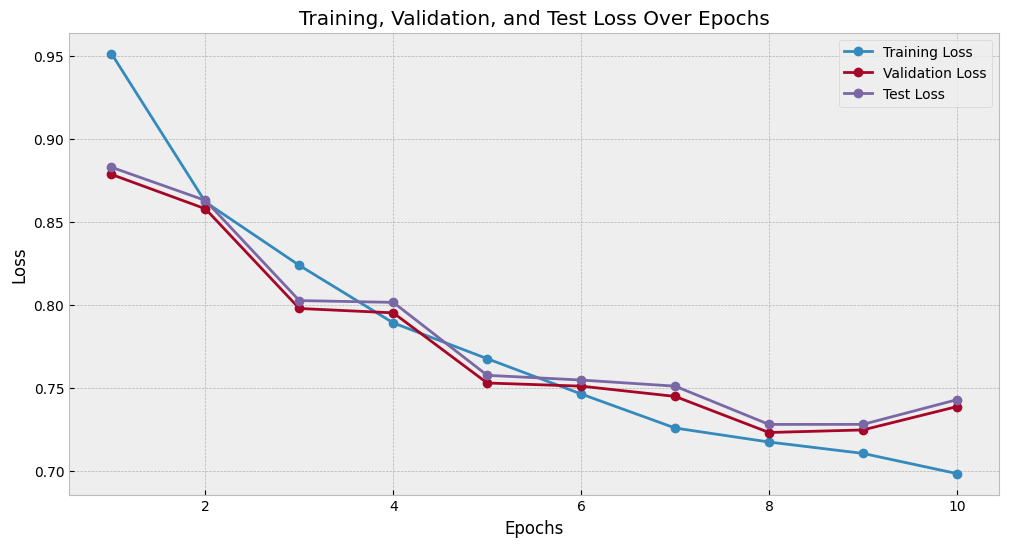

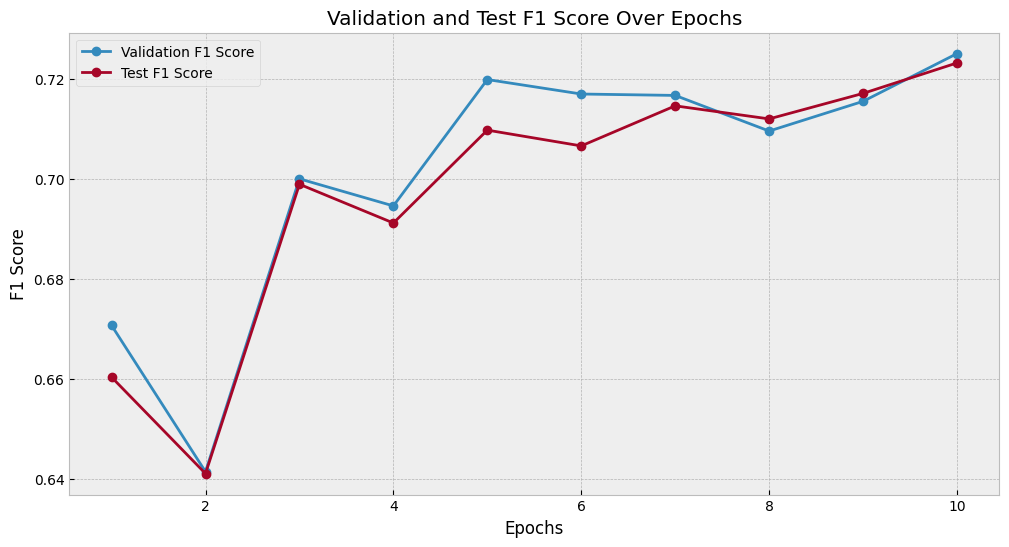

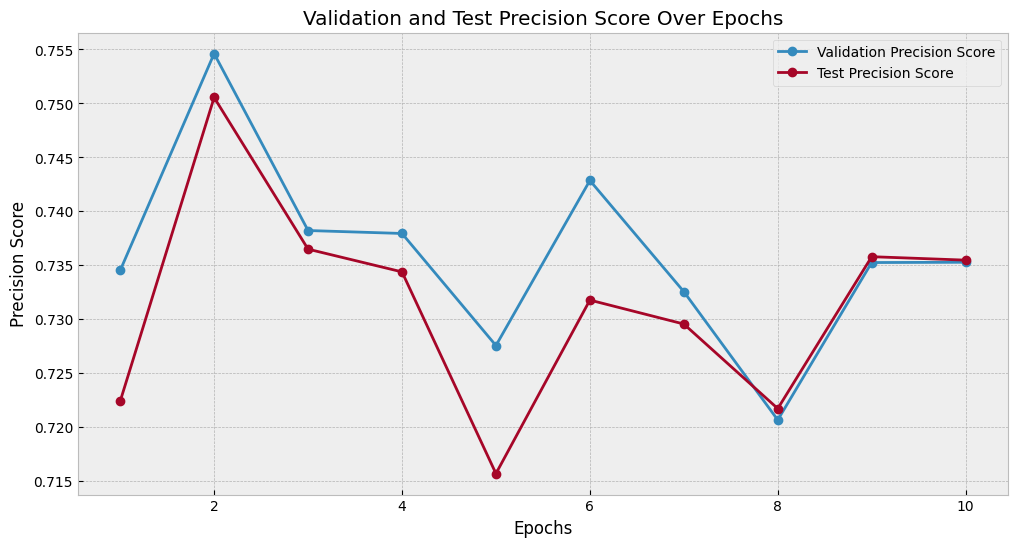

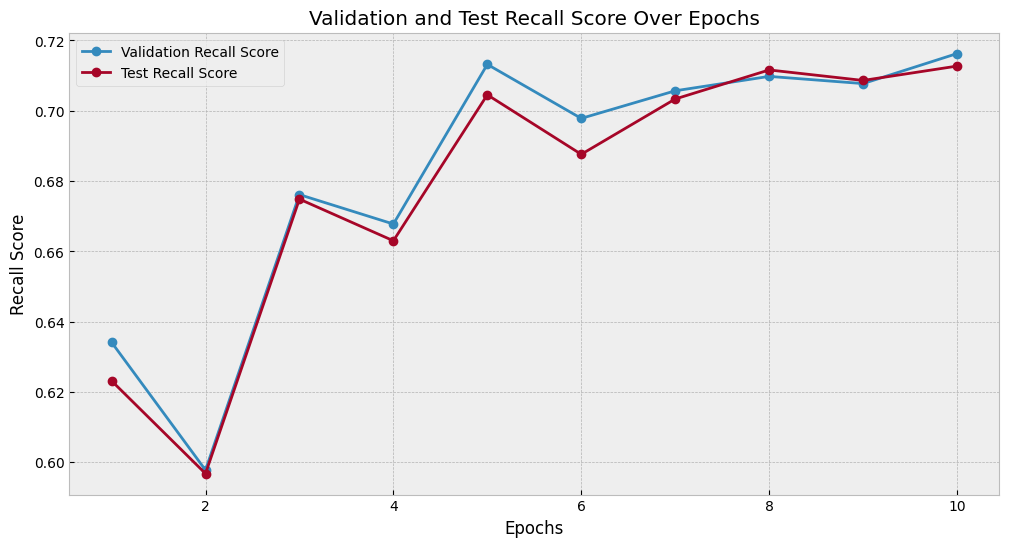

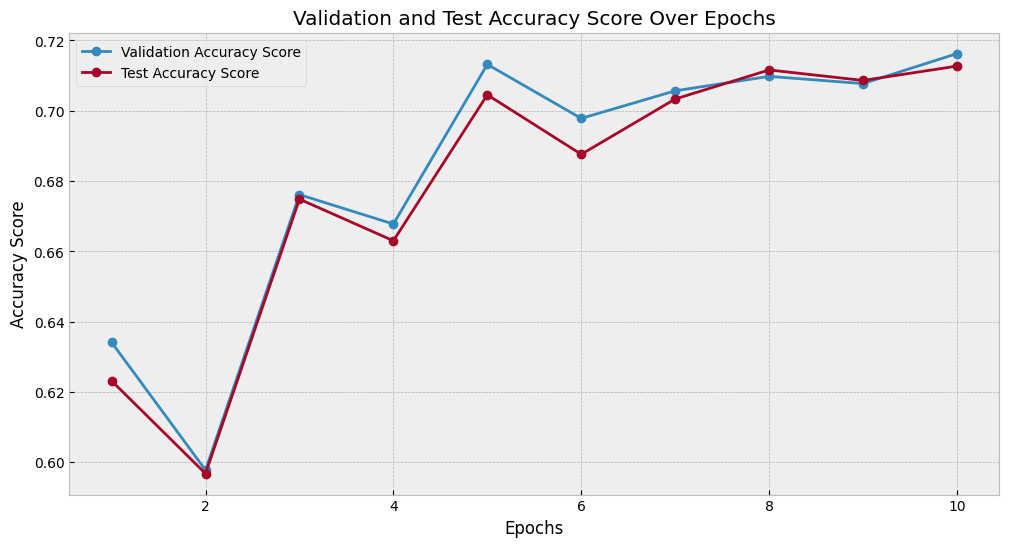

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Menggunakan range(1, num_epochs + 1) untuk sumbu x
epochs = range(1, num_epochs + 1)

# Plot training loss, validation loss, dan test loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.title('Training, Validation, and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1 Score pada validasi dan test
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_f1_scores, label='Validation F1 Score', marker='o')
plt.plot(epochs, test_f1_scores, label='Test F1 Score', marker='o')
plt.title('Validation and Test F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision Score pada validasi dan test
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_precisions, label='Validation Precision Score', marker='o')
plt.plot(epochs, test_precisions, label='Test Precision Score', marker='o')
plt.title('Validation and Test Precision Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Recall Score pada validasi dan test
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_recalls, label='Validation Recall Score', marker='o')
plt.plot(epochs, test_recalls, label='Test Recall Score', marker='o')
plt.title('Validation and Test Recall Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy Score pada validasi dan test
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_accuracies, label='Validation Accuracy Score', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy Score', marker='o')
plt.title('Validation and Test Accuracy Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()


In [41]:
import pandas as pd

# Menggabungkan data dalam bentuk dictionary
data = {
    'Epoch': list(range(1, num_epochs + 1)),
    'Training Loss': train_losses,
    'Validation Loss': val_losses,
    'Test Loss': test_losses,
    'Validation F1 Score': val_f1_scores,
    'Validation Precision Score': val_precisions,
    'Validation Recall Score': val_recalls,
    'Validation Accuracy Score': val_accuracies,
    'Test F1 Score': test_f1_scores,
    'Test Precision Score': test_precisions,
    'Test Recall Score': test_recalls,
    'Test Accuracy Score': test_accuracies
}

# Buat DataFrame dari dictionary
df = pd.DataFrame(data)

# Tampilkan DataFrame
print(df)


   Epoch  Training Loss  Validation Loss  Test Loss  Validation F1 Score  \
0      1       0.951162         0.878397   0.882709             0.670757   
1      2       0.861786         0.857700   0.862743             0.641487   
2      3       0.823621         0.797663   0.802420             0.700072   
3      4       0.788994         0.795035   0.801340             0.694654   
4      5       0.767434         0.752795   0.757430             0.719930   
5      6       0.746182         0.750895   0.754577             0.717037   
6      7       0.725683         0.744721   0.750896             0.716757   
7      8       0.717245         0.722981   0.727847             0.709631   
8      9       0.710394         0.724531   0.727875             0.715572   
9     10       0.698242         0.738577   0.742727             0.725126   

   Validation Precision Score  Validation Recall Score  \
0                    0.734503                 0.634113   
1                    0.754620                 0

314/314 [==============================] - 2s 7ms/step


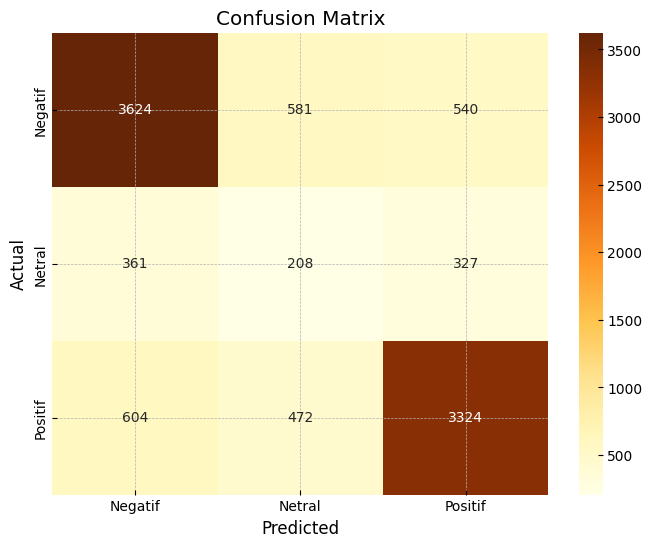

In [42]:
# Evaluasi model pada data uji
test_loss, test_accuracy = model.evaluate(word_seq_test, test_labels, verbose=0)
test_predictions = model.predict(word_seq_test)
test_predictions = np.argmax(test_predictions, axis=1)

# Membuat confusion matrix
confusion = confusion_matrix(np.argmax(test_labels, axis=1), test_predictions)

# Daftar label kelas
class_labels = ["Negatif", "Netral", "Positif"]

# Membuat heatmap dari confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='YlOrBr', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [43]:
# Tampilkan hasil prediksi dan label yang sebenarnya
for i in range(len(test_predictions)):
    print(f'Prediksi: {test_predictions[i]}, Label Sebenarnya: {np.argmax(test_labels[i])}')


Streaming output truncated to the last 5000 lines.
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 0, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 1, Label Sebenarnya: 0
Prediksi: 0, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 1
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 1
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 1, Label Sebenarnya: 0
Prediksi: 1, Label Sebenarnya: 1
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 1
Prediksi: 2, Label Sebenarnya: 1
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 0, Label Sebena